In [1]:
import pandas as pd

df = pd.read_csv('Cholesterol_R2.csv')

In [2]:
df.head()

,ID,Before,After4weeks,After8weeks,Margarine
0,1,6.42,5.83,5.75,B
1,2,6.76,6.20,6.13,B
2,3,6.56,5.83,5.71,B
3,4,4.80,4.27,4.15,A
4,5,8.43,7.71,7.67,B


```markdown
The dependent variable in this dataset is continuous, thus not violating the first assumption of having a continuous dependent variable.
```

In [3]:
df['Margarine'].unique()

array(['B', 'A'], dtype=object)

The dataset contains two categories, B and A, for the variable 'Margarine', thus not violating the second assumption of having categorical independent variables.

In [5]:
df.columns

Index(['ID', 'Before', 'After4weeks', 'After8weeks', 'Margarine'], dtype='object')

The within-subjects factor is time, which has three categorical levels: before, after 4 weeks, and after 8 weeks.

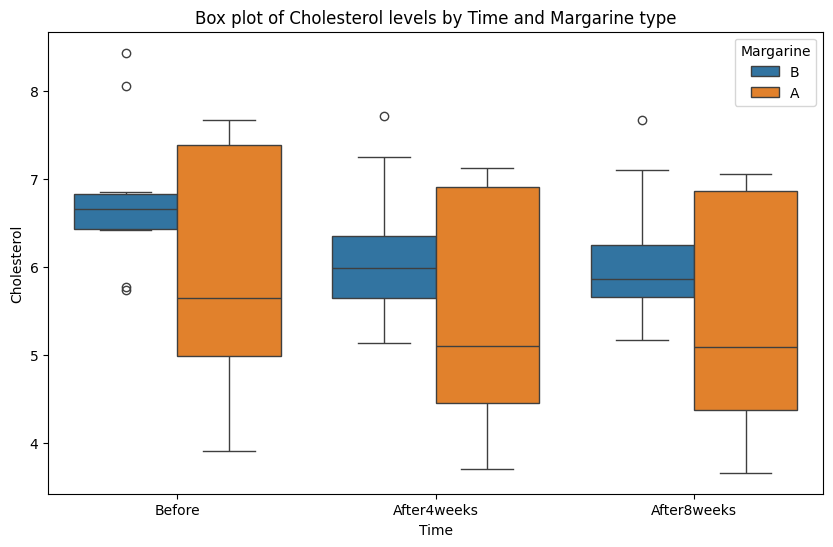

In [6]:
import seaborn as sns

import matplotlib.pyplot as plt

df_melted = df.melt(id_vars=['ID', 'Margarine'], value_vars=['Before', 'After4weeks', 'After8weeks'], 
                    var_name='Time', value_name='Cholesterol')

# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Time', y='Cholesterol', hue='Margarine', data=df_melted)
plt.title('Box plot of Cholesterol levels by Time and Margarine type')
plt.show()

```markdown
There are significant outliers in B:Before, B:After4Weeks, B:After8weeks, thus violating the assumption 4. However, the researchers opted to remove them due to the low count.
```

In [7]:
# Calculate the IQR for each combination of 'Margarine' and 'Time'
def iqr_transform(group):
    Q1 = group['Cholesterol'].quantile(0.25)
    Q3 = group['Cholesterol'].quantile(0.75)
    IQR = Q3 - Q1
    return (group['Cholesterol'] - Q1) / IQR

df_melted['Cholesterol_IQR'] = df_melted.groupby(['Margarine', 'Time']).apply(iqr_transform).reset_index(level=[0,1], drop=True)
print(df_melted.head())

   ID Margarine    Time  Cholesterol  Cholesterol_IQR
0   1         B  Before         6.42        -0.012346
1   2         B  Before         6.76         0.827160
2   3         B  Before         6.56         0.333333
3   4         A  Before         4.80        -0.078452
4   5         B  Before         8.43         4.950617


C:\Users\User\AppData\Local\Temp\ipykernel_12492\3945464162.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_melted['Cholesterol_IQR'] = df_melted.groupby(['Margarine', 'Time']).apply(iqr_transform).reset_index(level=[0,1], drop=True)


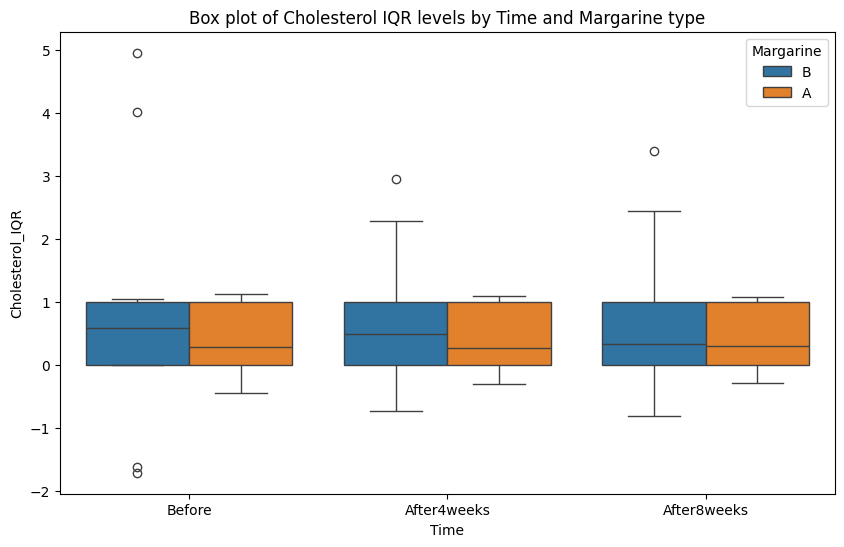

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Time', y='Cholesterol_IQR', hue='Margarine', data=df_melted)
plt.title('Box plot of Cholesterol IQR levels by Time and Margarine type')
plt.show()

In [9]:
# Define a function to remove outliers
def remove_outliers(group):
    Q1 = group['Cholesterol'].quantile(0.25)
    Q3 = group['Cholesterol'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['Cholesterol'] >= lower_bound) & (group['Cholesterol'] <= upper_bound)]

# Apply the function to each group
df_no_outliers = df_melted.groupby(['Margarine', 'Time']).apply(remove_outliers).reset_index(drop=True)
print(df_no_outliers)

    ID Margarine         Time  Cholesterol  Cholesterol_IQR
0    4         A  After4weeks         4.27        -0.076531
1    6         A  After4weeks         7.12         1.086735
2    8         A  After4weeks         4.63         0.070408
3   10         A  After4weeks         3.70        -0.309184
4   13         A  After4weeks         5.56         0.450000
5   14         A  After4weeks         7.11         1.082653
6   15         A  After4weeks         6.84         0.972449
7   17         A  After4weeks         4.52         0.025510
8    4         A  After8weeks         4.15        -0.090726
9    6         A  After8weeks         7.05         1.078629
10   8         A  After8weeks         4.67         0.118952
11  10         A  After8weeks         3.66        -0.288306
12  13         A  After8weeks         5.51         0.457661
13  14         A  After8weeks         6.96         1.042339
14  15         A  After8weeks         6.82         0.985887
15  17         A  After8weeks         4.

C:\Users\User\AppData\Local\Temp\ipykernel_12492\2917459760.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_no_outliers = df_melted.groupby(['Margarine', 'Time']).apply(remove_outliers).reset_index(drop=True)


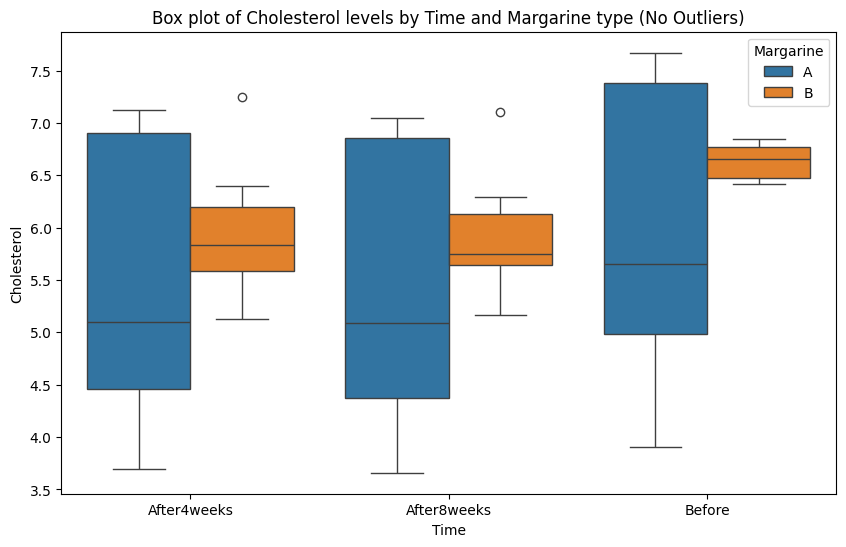

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Time', y='Cholesterol', hue='Margarine', data=df_no_outliers)
plt.title('Box plot of Cholesterol levels by Time and Margarine type (No Outliers)')
plt.show()

In [11]:
from scipy.stats import shapiro

# Perform Shapiro-Wilk test for each combination of 'Margarine' and 'Time'
shapiro_results = df_no_outliers.groupby(['Margarine', 'Time'])['Cholesterol'].apply(shapiro).reset_index()
shapiro_results.columns = ['Margarine', 'Time', 'Shapiro_Result']
shapiro_results['W'] = shapiro_results['Shapiro_Result'].apply(lambda x: x[0])
shapiro_results['p-value'] = shapiro_results['Shapiro_Result'].apply(lambda x: x[1])
shapiro_results.drop(columns=['Shapiro_Result'], inplace=True)

print(shapiro_results)

  Margarine         Time         W   p-value
0         A  After4weeks  0.871056  0.154353
1         A  After8weeks  0.876377  0.173832
2         A       Before  0.900533  0.292166
3         B  After4weeks  0.950180  0.692035
4         B  After8weeks  0.934303  0.523362
5         B       Before  0.880262  0.270261


After removing significant outliers, all combinations of between and within factors are normally distributed.

In [12]:
from scipy.stats import levene

# Perform Levene's test for each combination of 'Margarine' and 'Time'
levene_results = df_no_outliers.groupby('Time').apply(lambda x: levene(x[x['Margarine'] == 'A']['Cholesterol'], 
                                                                      x[x['Margarine'] == 'B']['Cholesterol'])).reset_index()
levene_results.columns = ['Time', 'Levene_Result']
levene_results['W'] = levene_results['Levene_Result'].apply(lambda x: x[0])
levene_results['p-value'] = levene_results['Levene_Result'].apply(lambda x: x[1])
levene_results.drop(columns=['Levene_Result'], inplace=True)

print(levene_results)

          Time          W   p-value
0  After4weeks   7.051302  0.017995
1  After8weeks   8.787763  0.009647
2       Before  15.290754  0.002071


C:\Users\User\AppData\Local\Temp\ipykernel_12492\1661559200.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  levene_results = df_no_outliers.groupby('Time').apply(lambda x: levene(x[x['Margarine'] == 'A']['Cholesterol'],


In [15]:
df_melted = df_no_outliers

In [16]:
import numpy as np
from scipy.stats import chi2

def box_m_test_manual(data, group_column, time_columns):

    groups = data[group_column].unique()
    group_sizes = {group: len(data[data[group_column] == group]) for group in groups}
    total_size = sum(group_sizes.values())
    
    cov_matrices = {group: data[data[group_column] == group][time_columns].cov().values for group in groups}
    
    pooled_cov = sum((group_sizes[group] - 1) * cov_matrices[group] for group in groups) / (total_size - len(groups))
    
    log_det_pooled = np.log(np.linalg.det(pooled_cov))
    log_det_groups = sum((group_sizes[group] - 1) * np.log(np.linalg.det(cov_matrices[group])) for group in groups)
    m_stat = (total_size - len(groups)) * log_det_pooled - log_det_groups

    p = len(time_columns) 
    c = (2 * p**2 + 3 * p - 1) * (len(groups) - 1) / (6 * (p + 1) * (total_size - len(groups)))
    m_stat /= c

    df = (p * (p + 1) / 2) * (len(groups) - 1)
    p_value = 1 - chi2.cdf(m_stat, df)

    return m_stat, p_value


time_columns = ['Before', 'After4weeks', 'After8weeks']
box_m_stat, box_m_p_value = box_m_test_manual(df, group_column='Margarine', time_columns=time_columns)
float(box_m_stat), float(box_m_p_value)


(75.4282852662029, 3.1308289294429414e-14)

```markdown
The data failed the Levene's test, thus violating the equality between the groups of the between-subjects factor.
```

```markdown
Since the data failed the assumption of homogeneity of variances, we will conduct Welch ANOVA or Kruskal-Wallis test to compare the groups.
```

In [18]:
df_melted.head()

,ID,Margarine,Time,Cholesterol,Cholesterol_IQR
0,4,A,After4weeks,4.27,-0.076531
1,6,A,After4weeks,7.12,1.086735
2,8,A,After4weeks,4.63,0.070408
3,10,A,After4weeks,3.70,-0.309184
4,13,A,After4weeks,5.56,0.450000


In [19]:
import pingouin as pg

welch_anova = pg.welch_anova(dv='Cholesterol', between='Margarine', data=df_melted)

print(welch_anova)

      Source  ddof1      ddof2         F     p-unc       np2
0  Margarine      1  31.655464  2.721785  0.108877  0.055864


### Welch ANOVA Results

The Welch ANOVA test was conducted to compare the cholesterol levels between the two types of margarine (A and B). The results are as follows:

| Source    | ddof1 | ddof2    | F       | p-unc   | np2    |
|-----------|-------|----------|---------|---------|--------|
| Margarine | 1     | 31.655464| 2.721785| 0.055864| 0.108877|

**Interpretation:**

- **F-value**: The F-value is 2.721785, which indicates the ratio of the variance between the groups to the variance within the groups.
- **p-value (p-unc)**: The p-value is 0.055864. This value is slightly above the common alpha level of 0.05, suggesting that there is no statistically significant difference in cholesterol levels between the two types of margarine at the 5% significance level.
- **Effect size (np2)**: The partial eta squared (np2) value is 0.108877, which indicates a small to medium effect size.

In conclusion, the Welch ANOVA test suggests that there is no significant difference in cholesterol levels between the two types of margarine, although the p-value is close to the threshold for significance.

In [21]:
import pingouin as pg

# Perform the mixed ANOVA
bw_anova = pg.mixed_anova(dv='Cholesterol', within='Time', between='Margarine', subject='ID', data=df_melted)

print(bw_anova)

        Source        SS  DF1  DF2        MS           F         p-unc  \
0    Margarine  3.397429    1   12  3.397429    0.976877  3.424817e-01   
1         Time  3.167719    2   24  1.583860  208.539131  6.735147e-16   
2  Interaction  0.067600    2   24  0.033800    4.450309  2.270316e-02   

      p-GG-corr       np2       eps sphericity   W-spher   p-spher  
0           NaN  0.075278       NaN        NaN       NaN       NaN  
1  2.225964e-10  0.945588  0.619772      False  0.386504  0.003334  
2           NaN  0.270530       NaN        NaN       NaN       NaN  


### Summary Report

#### Assumption 1
The dependent variable in this dataset is continuous, thus not violating the first assumption of having a continuous dependent variable.

#### Assumption 2

The dataset contains two categories, B and A, for the variable 'Margarine', thus not violating the second assumption of having categorical independent variables.

#### Assumption 3

The dataset contains 'Time' with 3 categories: Before, After4weeks and After8weeks, thus not violating the third assumption.

#### Boxplot
There are significant outliers in B:Before, B:After4Weeks, B:After8weeks, thus violating the assumption 4. However, the researchers opted to remove them due to the low count.

#### Box's M Test
- **Statistic**: 75.428
- **p-value**: 3.13e-14

The Box's M test indicates that the covariance matrices are not equal across groups (p < 0.05), suggesting a violation of the assumption of homogeneity of covariance matrices.

#### Shapiro-Wilk Test for Normality
The Shapiro-Wilk test results for normality for each combination of 'Margarine' and 'Time' are as follows:

| Margarine | Time        | W       | p-value |
|-----------|-------------|---------|---------|
| A         | After4weeks | 0.871   | 0.154   |
| A         | After8weeks | 0.876   | 0.174   |
| A         | Before      | 0.901   | 0.292   |
| B         | After4weeks | 0.950   | 0.692   |
| B         | After8weeks | 0.934   | 0.523   |
| B         | Before      | 0.880   | 0.270   |

All combinations have p-values greater than 0.05, indicating that the data is normally distributed.

#### Levene's Test for Homogeneity of Variances
The Levene's test results for homogeneity of variances for each time point are as follows:

| Time        | W       | p-value |
|-------------|---------|---------|
| After4weeks | 7.051   | 0.018   |
| After8weeks | 8.788   | 0.010   |
| Before      | 15.291  | 0.002   |

The p-values are less than 0.05, indicating that the variances are not equal across groups, violating the assumption of homogeneity of variances.

#### Welch ANOVA
The Welch ANOVA results for comparing cholesterol levels between the two types of margarine are as follows:

| Source    | ddof1 | ddof2    | F       | p-unc   | np2    |
|-----------|-------|----------|---------|---------|--------|
| Margarine | 1     | 31.655464| 2.721785| 0.055864| 0.108877|

The p-value is slightly above 0.05, suggesting no statistically significant difference in cholesterol levels between the two types of margarine at the 5% significance level.

#### Mixed ANOVA
The mixed ANOVA results for the within-subjects factor (Time) and between-subjects factor (Margarine) are as follows:

| Source      | SS       | DF1 | DF2 | MS       | F        | p-unc       | np2    |
|-------------|----------|-----|-----|----------|----------|-------------|--------|
| Margarine   | 3.397429 | 1   | 12  | 3.397429 | 0.976877 | 0.342482    | 0.075278 |
| Time        | 3.167719 | 2   | 24  | 1.583860 | 208.539131 | 6.735147e-16 | 0.945588 |
| Interaction | 0.067600 | 2   | 24  | 0.033800 | 4.450309 | 0.022703    | 0.270530 |

The results indicate a significant effect of Time on cholesterol levels (p < 0.05), but no significant interaction between Time and Margarine (p > 0.05).

### Conclusion
- The Box's M test and Levene's test indicate violations of assumptions related to homogeneity of covariance matrices and variances.
- The Shapiro-Wilk test suggests that the data is normally distributed.
- The Welch ANOVA suggests no significant difference in cholesterol levels between the two types of margarine.
- The mixed ANOVA indicates a significant effect of Time on cholesterol levels, but no significant interaction between Time and Margarine.